In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from power_control import power_control_dpc, graf_sinr_and_power, control_power_fdm, analysis

# Exercise 10

In [27]:
sinr, power = power_control_dpc(scenario_type = "default", target_sinr=0.5, pmax=1, pmin=0, number_of_iterations=20)

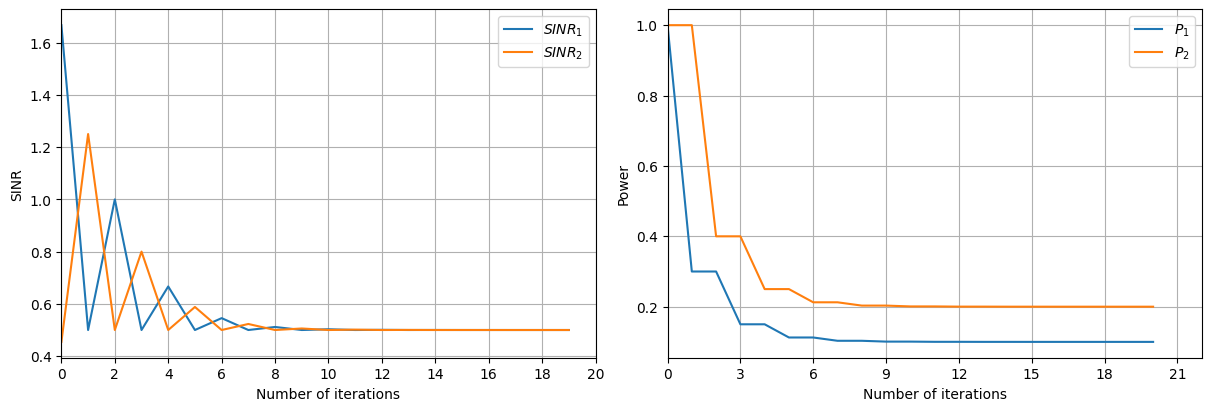

In [28]:
graf_sinr_and_power(number_ue = 2, value_sinr=sinr, value_power=power)

**Comentário:**


# Exercise 11

## Noise-limited scenario

In [29]:
print("No power control - Noise-limited scenario")

analysis(scenario_type="Noise-limited", power=[1]*4)

No power control - Noise-limited scenario

SINR for UE 1:  4.57
Channel Capacity for UE 1: 247.84 Mbps

SINR for UE 2:  0.01
Channel Capacity for UE 2: 1.11 Mbps

SINR for UE 3:  0.80
Channel Capacity for UE 3: 85.14 Mbps

SINR for UE 4:  0.01
Channel Capacity for UE 4: 1.32 Mbps


Sum Capacity: 335.40 Mbps
Energy Efficiency: 83.85 Mbits/J


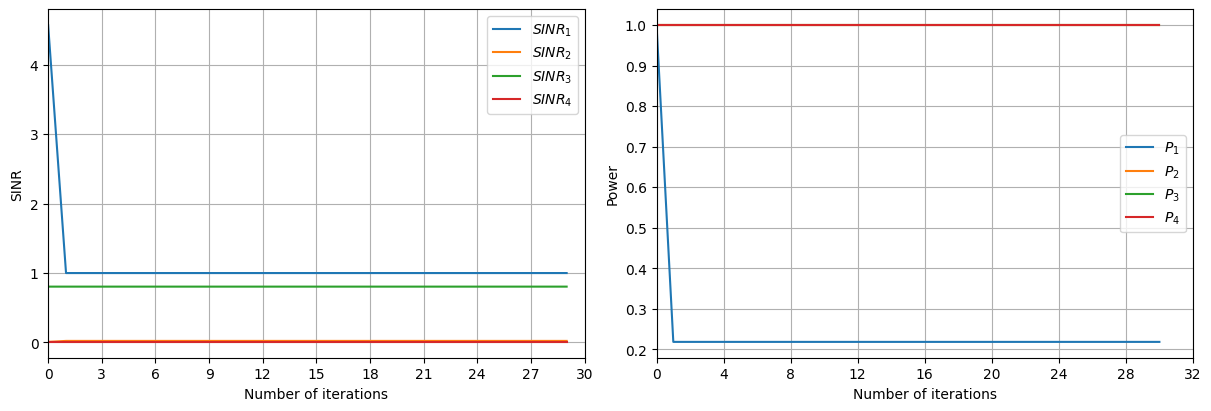

In [30]:
sinr_nl, power_nl = power_control_dpc(scenario_type="Noise-limited", target_sinr=1, pmax=1, pmin=1e-3, number_of_iterations = 30)

graf_sinr_and_power(number_ue = 4, value_sinr=sinr_nl, value_power=power_nl)

In [31]:
print("Power control - Noise-limited scenario")
analysis(scenario_type="Noise-limited", power=power_nl[-1])

Power control - Noise-limited scenario

SINR for UE 1:  1.00
Channel Capacity for UE 1: 100.00 Mbps

SINR for UE 2:  0.02
Channel Capacity for UE 2: 3.11 Mbps

SINR for UE 3:  0.80
Channel Capacity for UE 3: 85.14 Mbps

SINR for UE 4:  0.01
Channel Capacity for UE 4: 1.32 Mbps


Sum Capacity: 189.56 Mbps
Energy Efficiency: 58.89 Mbits/J


## Interference-limited scenario

In [32]:
print("No power control - Interference-limited scenario")
analysis(scenario_type="Interference-limited", power=[1]*4)

No power control - Interference-limited scenario

SINR for UE 1:  92.69
Channel Capacity for UE 1: 654.98 Mbps

SINR for UE 2:  0.01
Channel Capacity for UE 2: 1.34 Mbps

SINR for UE 3:  89.21
Channel Capacity for UE 3: 649.52 Mbps

SINR for UE 4:  7.69
Channel Capacity for UE 4: 311.86 Mbps


Sum Capacity: 1617.70 Mbps
Energy Efficiency: 404.42 Mbits/J


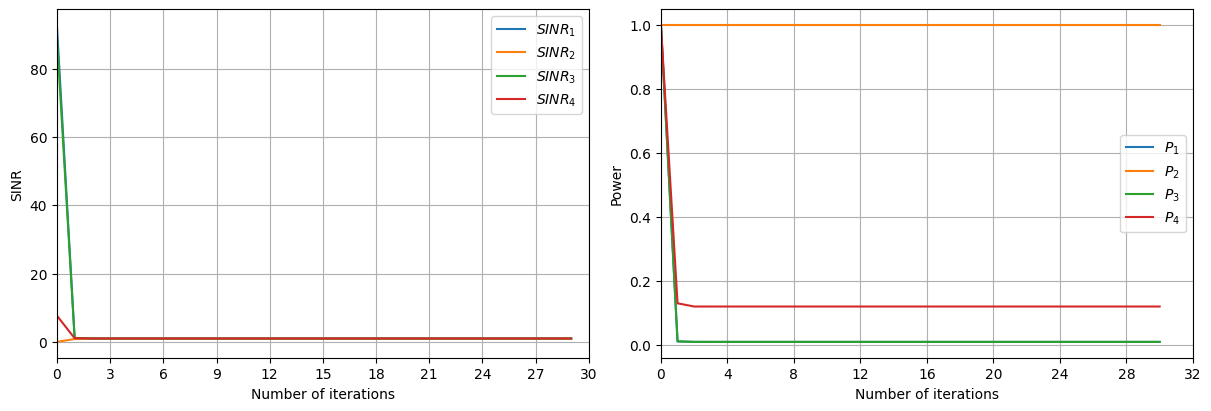

In [33]:
sinr_il, power_il = power_control_dpc(scenario_type="Interference-limited", target_sinr=1, pmax=1, pmin=1e-3, number_of_iterations = 30)

graf_sinr_and_power(number_ue = 4, value_sinr=sinr_il, value_power=power_il)

In [34]:
print("Power control - Interference-limited scenario")
analysis(scenario_type="Interference-limited", power=power_il[-1])

Power control - Interference-limited scenario

SINR for UE 1:  1.00
Channel Capacity for UE 1: 100.00 Mbps

SINR for UE 2:  0.96
Channel Capacity for UE 2: 97.29 Mbps

SINR for UE 3:  1.00
Channel Capacity for UE 3: 100.00 Mbps

SINR for UE 4:  1.00
Channel Capacity for UE 4: 100.00 Mbps


Sum Capacity: 397.29 Mbps
Energy Efficiency: 348.80 Mbits/J


# Exercise 12

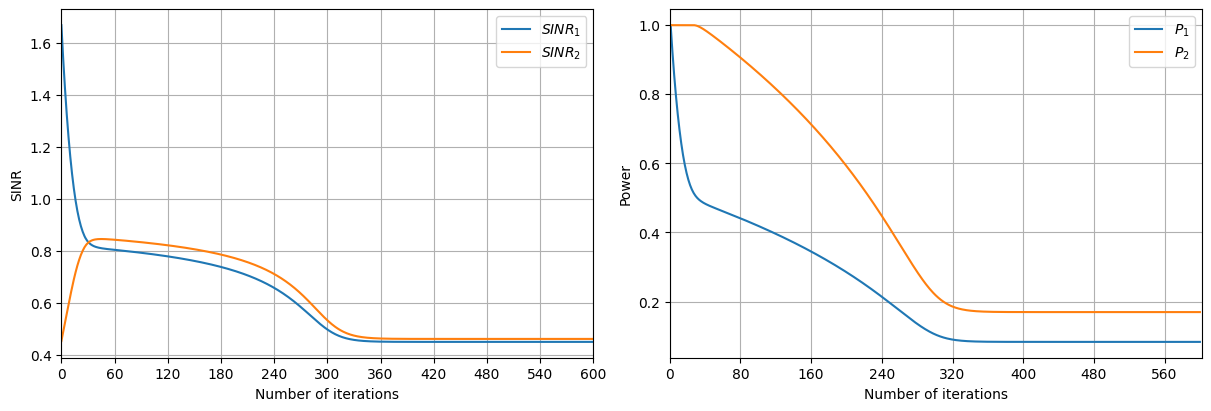

In [35]:
sinr_fdm, power_fdm = control_power_fdm(scenario_type="default", target_sinr=0.5, pmax=1, pmin=0, number_of_iterations=600)

graf_sinr_and_power(number_ue=2, value_sinr=sinr_fdm, value_power=power_fdm)

**Comentário:**


# Exercise 13

## Noise-limited scenario

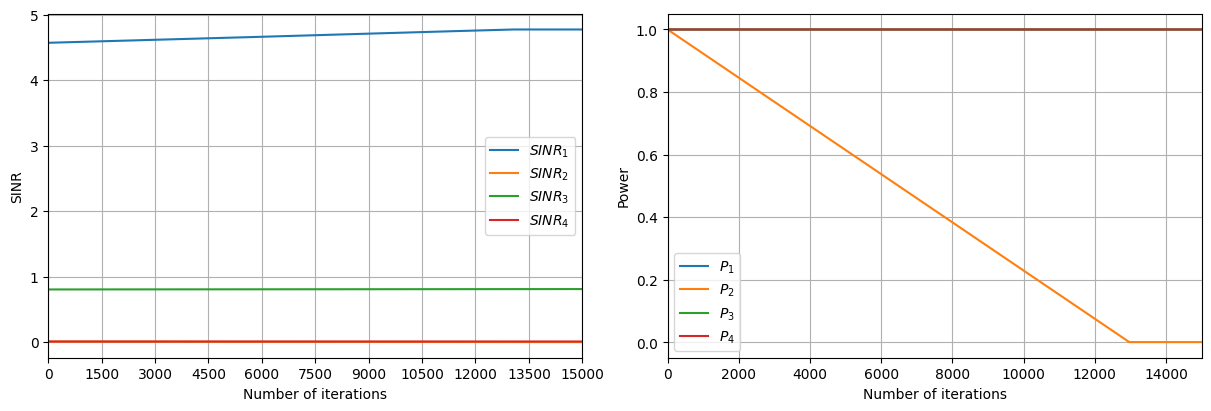

In [36]:
sinr_fdm_nl_j1, power_fdm_nl_j1 = control_power_fdm(scenario_type="Noise-limited", type_objective="J1", number_of_iterations=15000)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_nl_j1, value_power=power_fdm_nl_j1)

In [37]:
print("Power control - Noise-limited scenario - Objective J1")
analysis(scenario_type="Noise-limited", power=power_fdm_nl_j1[-1])

Power control - Noise-limited scenario - Objective J1

SINR for UE 1:  4.78
Channel Capacity for UE 1: 253.01 Mbps

SINR for UE 2:  0.00
Channel Capacity for UE 2: 0.00 Mbps

SINR for UE 3:  0.81
Channel Capacity for UE 3: 85.61 Mbps

SINR for UE 4:  0.01
Channel Capacity for UE 4: 1.32 Mbps


Sum Capacity: 339.94 Mbps
Energy Efficiency: 113.27 Mbits/J


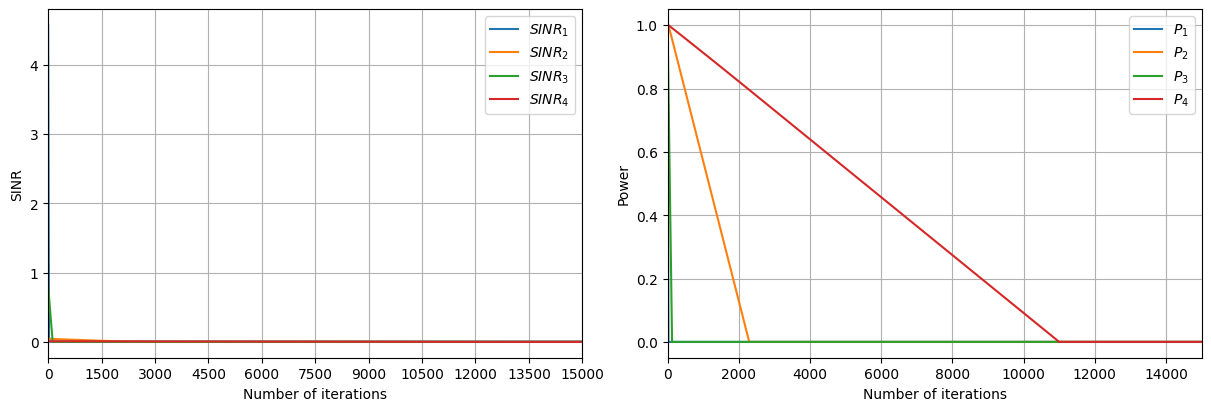

In [41]:
sinr_fdm_nl_j2, power_fdm_nl_j2 = control_power_fdm(scenario_type="Noise-limited", type_objective="J2", number_of_iterations=15000)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_nl_j2, value_power=power_fdm_nl_j2)

In [42]:
print("Power control - Noise-limited scenario - Objective J2")
analysis(scenario_type="Noise-limited", power=power_fdm_nl_j2[-1])

Power control - Noise-limited scenario - Objective J2

SINR for UE 1:  0.00
Channel Capacity for UE 1: 0.69 Mbps

SINR for UE 2:  0.00
Channel Capacity for UE 2: 0.01 Mbps

SINR for UE 3:  0.00
Channel Capacity for UE 3: 0.12 Mbps

SINR for UE 4:  0.00
Channel Capacity for UE 4: 0.00 Mbps


Sum Capacity: 0.82 Mbps
Energy Efficiency: 204.24 Mbits/J


## Interference-limited scenario

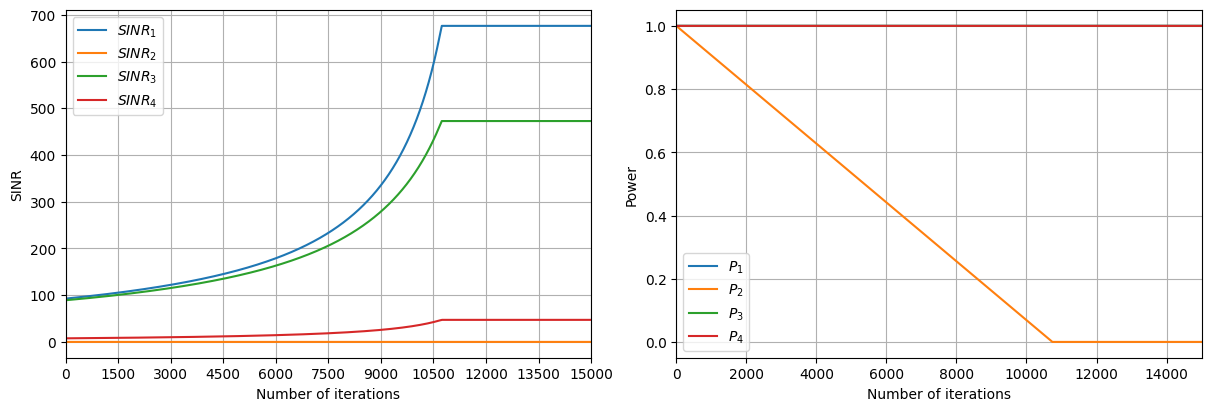

In [43]:
sinr_fdm_il_j1, power_fdm_il_j1 = control_power_fdm(scenario_type="Interference-limited", type_objective="J1", number_of_iterations=15000)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_il_j1, value_power=power_fdm_il_j1)

In [44]:
print("Power control - Interference-limited scenario - Objective J1")
analysis(scenario_type="Interference-limited", power=power_fdm_il_j1[-1])

Power control - Interference-limited scenario - Objective J1

SINR for UE 1:  676.40
Channel Capacity for UE 1: 940.39 Mbps

SINR for UE 2:  0.00
Channel Capacity for UE 2: 0.00 Mbps

SINR for UE 3:  472.71
Channel Capacity for UE 3: 888.79 Mbps

SINR for UE 4:  47.22
Channel Capacity for UE 4: 559.16 Mbps


Sum Capacity: 2388.33 Mbps
Energy Efficiency: 795.85 Mbits/J


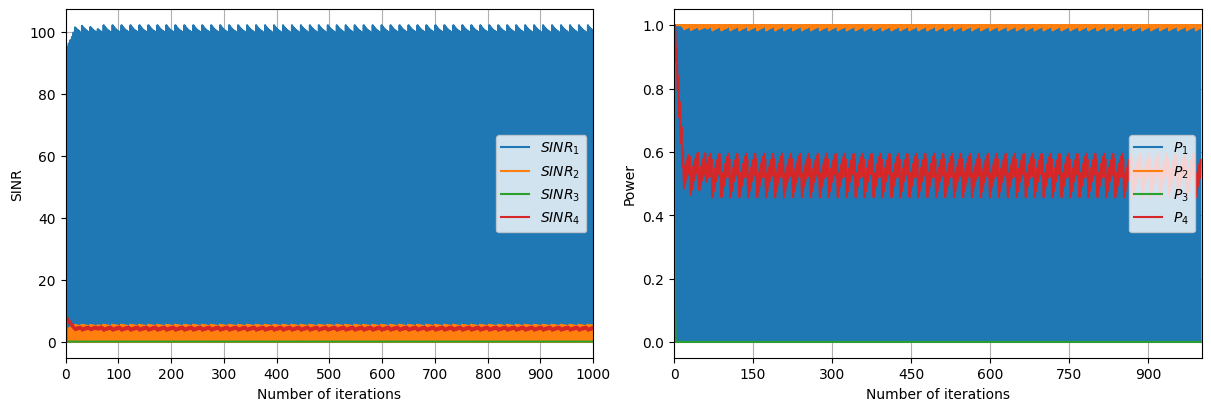

In [51]:
sinr_fdm_il_j2, power_fdm_il_j2 = control_power_fdm(scenario_type="Interference-limited", type_objective="J2", number_of_iterations=1000, eta=1e-2, mu=1e-2)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_il_j2, value_power=power_fdm_il_j2)

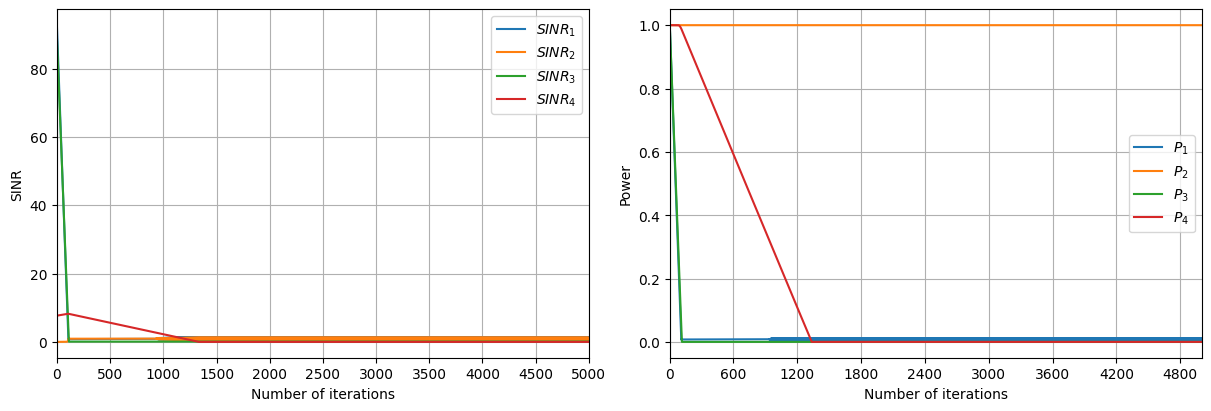

In [52]:
sinr_fdm_il_j2, power_fdm_il_j2 = control_power_fdm(scenario_type="Interference-limited", type_objective="J2", number_of_iterations=5000, eta=1e-4, mu=1e-4)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_il_j2, value_power=power_fdm_il_j2)

In [53]:
print("Power control - Interference-limited scenario - Objective J2")
analysis(scenario_type="Interference-limited", power=power_fdm_il_j2[-1])

Power control - Interference-limited scenario - Objective J2

SINR for UE 1:  1.33
Channel Capacity for UE 1: 122.24 Mbps

SINR for UE 2:  0.75
Channel Capacity for UE 2: 80.47 Mbps

SINR for UE 3:  0.11
Channel Capacity for UE 3: 14.84 Mbps

SINR for UE 4:  0.01
Channel Capacity for UE 4: 1.20 Mbps


Sum Capacity: 218.76 Mbps
Energy Efficiency: 215.65 Mbits/J


# Exercise 14

## Noise-limited scenario

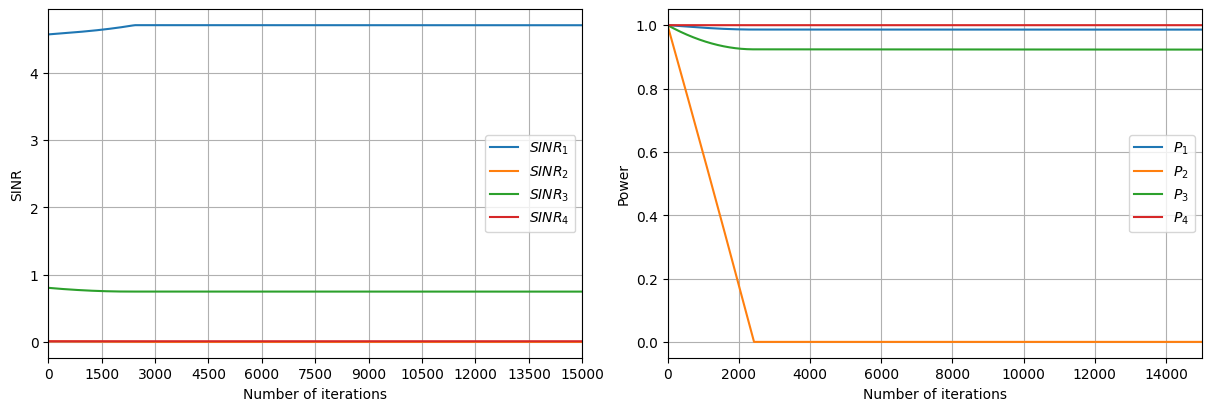

In [22]:
sinr_fdm_nl_j3, power_fdm_nl_j3 = control_power_fdm(scenario_type="Noise-limited", type_objective="J3", number_of_iterations=15000)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_nl_j3, value_power=power_fdm_nl_j3)

In [23]:
print("Power control - Noise-limited scenario - Objective J3")
analysis(scenario_type="Noise-limited", power=power_fdm_nl_j3[-1])

Power control - Noise-limited scenario - Objective J3

SINR for UE 1:  4.71
Channel Capacity for UE 1: 251.34 Mbps

SINR for UE 2:  0.00
Channel Capacity for UE 2: 0.00 Mbps

SINR for UE 3:  0.75
Channel Capacity for UE 3: 80.55 Mbps

SINR for UE 4:  0.01
Channel Capacity for UE 4: 1.32 Mbps


Sum Capacity: 333.20 Mbps
Energy Efficiency: 114.50 Mbits/J


## Interference-limited scenario

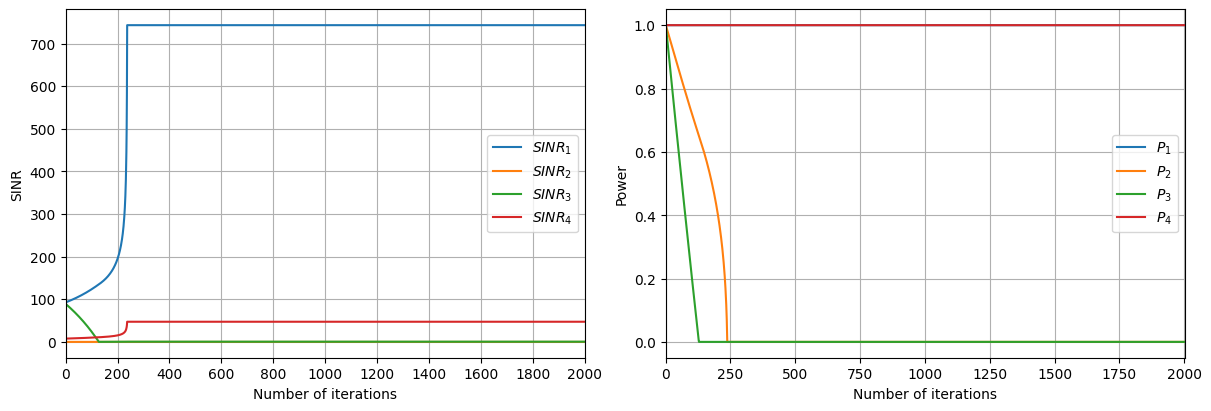

In [25]:
sinr_fdm_il_j3, power_fdm_il_j3 = control_power_fdm(scenario_type="Interference-limited", type_objective="J3", number_of_iterations=2000)
graf_sinr_and_power(number_ue=4, value_sinr=sinr_fdm_il_j3, value_power=power_fdm_il_j3)

In [26]:
print("Power control - Interference-limited scenario - Objective J3")
analysis(scenario_type="Interference-limited", power=power_fdm_il_j3[-1])

Power control - Interference-limited scenario - Objective J3

SINR for UE 1:  743.26
Channel Capacity for UE 1: 953.97 Mbps

SINR for UE 2:  0.00
Channel Capacity for UE 2: 0.00 Mbps

SINR for UE 3:  0.47
Channel Capacity for UE 3: 55.85 Mbps

SINR for UE 4:  47.28
Channel Capacity for UE 4: 559.33 Mbps


Sum Capacity: 1569.14 Mbps
Energy Efficiency: 783.79 Mbits/J
